<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Baseline_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SETUP

In [ ]:
#import os
#import tensorflow as tf
#import numpy as np
#import random as rn

#os.environ['PYTHONHASHSEED'] = '0'
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
#np.random.seed(37)
#tf.random.set_seed(89)

#import numpy as np
#import os
#import random
#import tensorflow as tf # 2.2.0

#SEED = 42
#os.environ['PYTHONHASHSEED']=str(SEED)
#os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1+
#np.random.seed(SEED)
#random.seed(SEED)
#tf.random.set_seed(SEED)

In [1]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# DATA PROCESSING

In [3]:
train_dir = '/content/drive/My Drive/Colab Notebooks/charts/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/charts/Validation'

In [4]:
img_width, img_height = 224, 224 
nb_train_samples = 560
nb_validation_samples = 140
epochs = 100
batch_size = 16

In [5]:
#checking whether the rgb channel is first or last to feed the input shape accordingly
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [ ]:
#Experimental block of code for hsv - has issues with range (0-255) which will not produce efficient training
#import cv2
#import numpy as np
#from PIL import Image
#def myFunc(image):
 #   image = np.array(image)
  #  hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
   # hsv_image = hsv_image.astype('float32')
    #hsv_image = hsv_image / 255.0
    #return Image.fromarray(hsv_image)

In [28]:
# Inspired by random crop functionality from https://jkjung-avt.github.io/keras-image-cropping/
def noisy_generator(batches):
    for batch_x, batch_y in batches:
        sigma = np.random.exponential(0.15)
        noise = np.random.normal(scale=sigma, size=batch_x.shape)
        batch_noisy = np.clip(batch_x + noise, 0, 1)
        yield (batch_noisy, batch_y)

In [29]:
#Performing augmentation on image scaling, zoom and flipping so that the network has more training samples
train_datagen = ImageDataGenerator( 
	rescale=1. / 255, 
	shear_range=0.2, 
	zoom_range=0.2, 
	channel_shift_range=150.0,
	brightness_range=(0.6,0.9) #Range starts from 0.6 so that the images dont become too dark for the model to recognize
	) 

#Not having any augmentation apart from scaling as the validation data should resemble the real-world data as close as possible
val_datagen = ImageDataGenerator(rescale=1. / 255) 

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

#Adding noise
train_noisy = noisy_generator(train_generator)

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [30]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

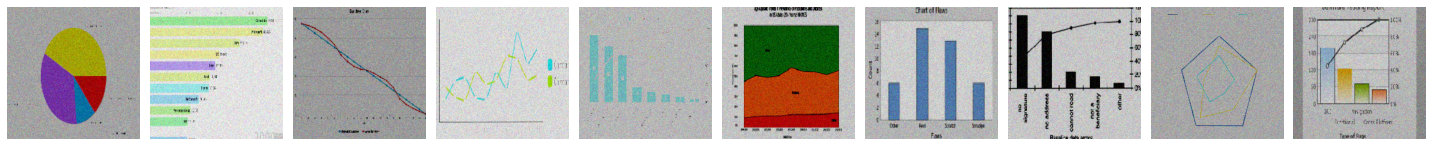

In [32]:
sample_training_images, _ = next(train_noisy)
plotImages(sample_training_images[:10])

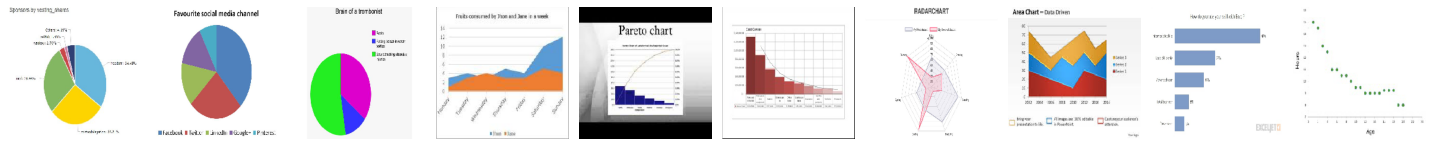

In [ ]:
sample_val_images, _ = next(validation_generator)
plotImages(sample_val_images[:10])

#BASELINE CNN MODEL

In [ ]:
# 3 CNN blocks containing a max pooling layer in each of them. On top of that is a fully connected layer with relu activation function
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])


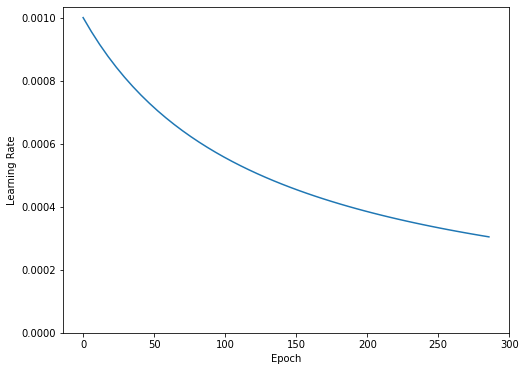

In [12]:
STEPS_PER_EPOCH = nb_train_samples // batch_size

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=8,
  staircase=False)

step = np.linspace(0,10000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)            

In [ ]:
#Since data aug is applied only to training and not on validation set, there might be epochs where the validation accuracy will be greater than
#the training accuracy in the initial few epochs
history = model.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 1/100
35/35 [==============================] - 16s 446ms/step - loss: 2.3437 - accuracy: 0.2268 - val_loss: 1.7033 - val_accuracy: 0.4609
Epoch 2/100
35/35 [==============================] - 16s 448ms/step - loss: 1.4224 - accuracy: 0.4500 - val_loss: 1.2942 - val_accuracy: 0.4453
Epoch 3/100
35/35 [==============================] - 15s 440ms/step - loss: 1.2617 - accuracy: 0.4946 - val_loss: 1.3865 - val_accuracy: 0.5547
Epoch 4/100
35/35 [==============================] - 16s 456ms/step - loss: 1.1034 - accuracy: 0.5607 - val_loss: 1.3614 - val_accuracy: 0.5156
Epoch 5/100
35/35 [==============================] - 16s 446ms/step - loss: 1.0556 - accuracy: 0.5893 - val_loss: 1.4075 - val_accuracy: 0.4922
Epoch 6/100
35/35 [==============================] - 16s 445ms/step - loss: 0.9604 - accuracy: 0.6250 - val_loss: 1.2911 - val_accuracy: 0.5312
Epoch 7/100
35/35 [==============================] - 15s 437ms/step - loss: 0.9837 - accuracy: 0.6339 - val_loss: 1.3853 - val_accuracy:

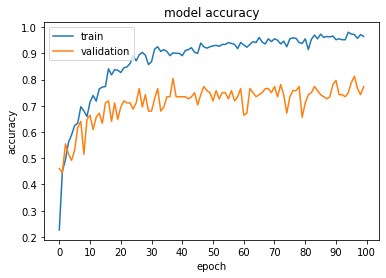

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

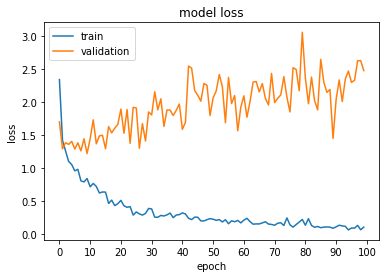

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,110, 10))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#ABLATION STUDY

# <H4>Remove data augementation, gaussian noise and learning rate scheduling - keep all classes

In [ ]:
train_datagen_2 = ImageDataGenerator(rescale=1. /255)
val_datagen_2 = ImageDataGenerator(rescale=1. / 255) 

train_generator_2 = train_datagen_2.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator_2 = val_datagen_2.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


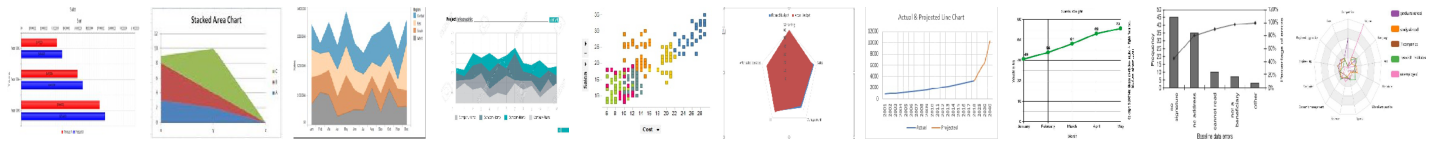

In [ ]:
sample_training_images, _ = next(train_generator_2)
plotImages(sample_training_images[:10])

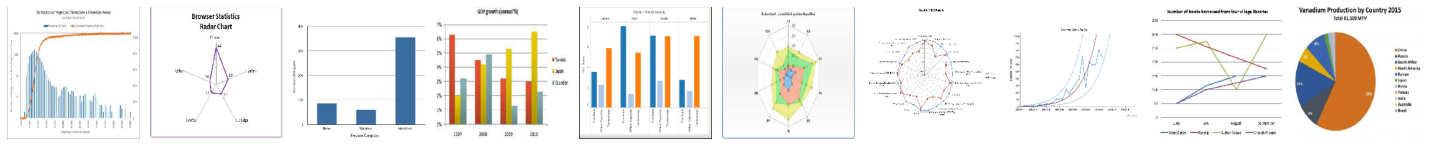

In [ ]:
sample_training_images, _ = next(validation_generator_2)
plotImages(sample_training_images[:10])

In [ ]:
model_repeat = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [ ]:
lr=0.001
model_repeat.compile(optimizer=keras.optimizers.Adam(lr) ,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 50176)            

In [ ]:
#Since data aug is applied only to training and not on validation set, there might be epochs where the validation accuracy will be greater than
#the training accuracy in the initial few epochs
history2 = model_repeat.fit( 
	train_generator_2, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator_2, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 1/100
35/35 [==============================] - 6s 169ms/step - loss: 2.8251 - accuracy: 0.2607 - val_loss: 1.4711 - val_accuracy: 0.5156
Epoch 2/100
35/35 [==============================] - 6s 167ms/step - loss: 1.0782 - accuracy: 0.6018 - val_loss: 1.0893 - val_accuracy: 0.6406
Epoch 3/100
35/35 [==============================] - 6s 165ms/step - loss: 0.5588 - accuracy: 0.7929 - val_loss: 1.2259 - val_accuracy: 0.6484
Epoch 4/100
35/35 [==============================] - 6s 168ms/step - loss: 0.3249 - accuracy: 0.8804 - val_loss: 1.1185 - val_accuracy: 0.7031
Epoch 5/100
35/35 [==============================] - 6s 168ms/step - loss: 0.1375 - accuracy: 0.9554 - val_loss: 1.4581 - val_accuracy: 0.7266
Epoch 6/100
35/35 [==============================] - 6s 169ms/step - loss: 0.0887 - accuracy: 0.9750 - val_loss: 1.3570 - val_accuracy: 0.7031
Epoch 7/100
35/35 [==============================] - 6s 170ms/step - loss: 0.0444 - accuracy: 0.9857 - val_loss: 1.8859 - val_accuracy: 0.6797

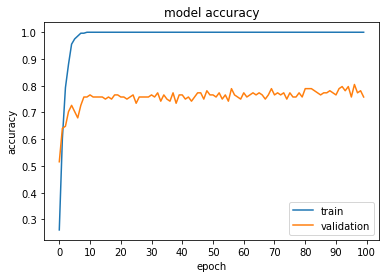

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

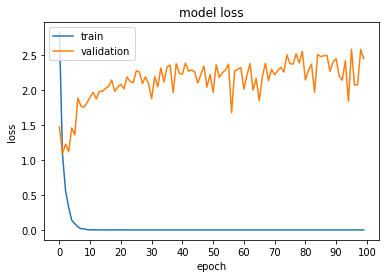

In [ ]:
# summarize history for loss https://www.kaggle.com/prateek0x/multiclass-image-classification-using-keras
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,110, 10))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# <H4> Remove gaussian noise and learning rate - keep data augmentation and all classes

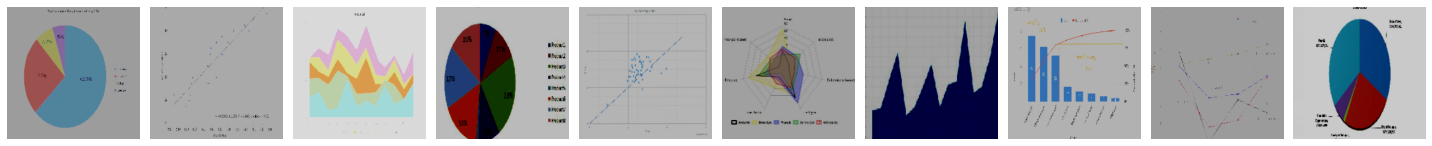

In [ ]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:10])

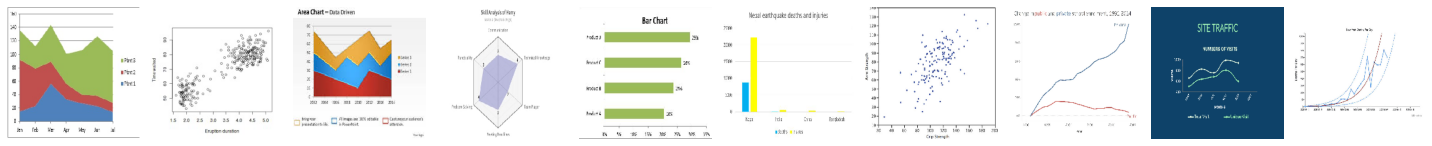

In [ ]:
sample_val_images, _ = next(validation_generator)
plotImages(sample_val_images[:10])

In [ ]:
model_repeat_3 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [ ]:
lr=0.001
model_repeat_3.compile(optimizer=keras.optimizers.Adam(lr) ,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 50176)            

In [ ]:
history3 = model_repeat_3.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
35/35 [==============================] - 11s 320ms/step - loss: 2.4126 - accuracy: 0.2089 - val_loss: 1.6280 - val_accuracy: 0.3594
Epoch 2/100
35/35 [==============================] - 11s 318ms/step - loss: 1.2629 - accuracy: 0.5161 - val_loss: 1.2380 - val_accuracy: 0.5703
Epoch 3/100
35/35 [==============================] - 11s 327ms/step - loss: 0.9611 - accuracy: 0.6321 - val_loss: 1.4495 - val_accuracy: 0.5469
Epoch 4/100
35/35 [==============================] - 11s 323ms/step - loss: 0.7842 - accuracy: 0.7161 - val_loss: 1.1518 - val_accuracy: 0.6172
Epoch 5/100
35/35 [==============================] - 11s 320ms/step - loss: 0.6593 - accuracy: 0.7625 - val_loss: 1.2407 - val_accuracy: 0.6250
Epoch 6/100
35/35 [==============================] - 11s 320ms/step - loss: 0.5692 - accuracy: 0.8000 - val_loss: 1.2253 - val_accuracy: 0.7266
Epoch 7/100
35/35 [==============================] - 11s 321ms/step - loss: 0.5064 - accuracy: 0.8143 - val_loss: 1.0660 - val_accuracy:

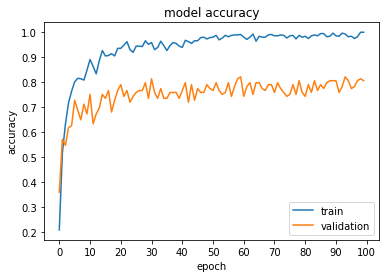

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

#<H4>Remove gaussian noise - keep learning rate scheduling, data augmentation and all classes

In [ ]:
model_repeat_4 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [ ]:
model_repeat_4.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat_4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)            

In [ ]:
history4 = model_repeat_4.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
35/35 [==============================] - 156s 4s/step - loss: 2.0686 - accuracy: 0.2518 - val_loss: 1.5908 - val_accuracy: 0.4219
Epoch 2/100
35/35 [==============================] - 11s 312ms/step - loss: 1.2838 - accuracy: 0.4982 - val_loss: 1.2507 - val_accuracy: 0.5859
Epoch 3/100
35/35 [==============================] - 11s 311ms/step - loss: 1.0149 - accuracy: 0.6036 - val_loss: 1.4794 - val_accuracy: 0.5859
Epoch 4/100
35/35 [==============================] - 11s 312ms/step - loss: 0.8984 - accuracy: 0.6732 - val_loss: 1.1171 - val_accuracy: 0.6250
Epoch 5/100
35/35 [==============================] - 11s 311ms/step - loss: 0.6467 - accuracy: 0.7857 - val_loss: 1.1416 - val_accuracy: 0.7188
Epoch 6/100
35/35 [==============================] - 11s 312ms/step - loss: 0.5701 - accuracy: 0.8143 - val_loss: 1.0938 - val_accuracy: 0.7188
Epoch 7/100
35/35 [==============================] - 11s 326ms/step - loss: 0.5171 - accuracy: 0.8250 - val_loss: 1.2129 - val_accuracy: 0

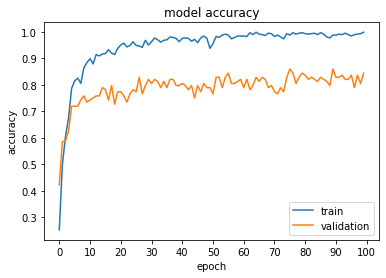

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

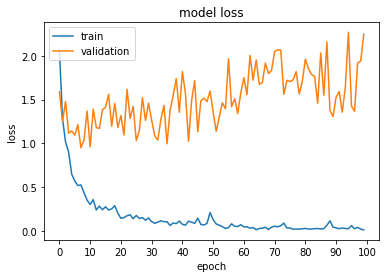

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,110, 10))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#<H4>Keep gaussian noise, learning rate scheduling & data aug - remove pareto chart and radar chart classes (only 5 charts)

In [19]:
train_generator_5 = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical',
  classes=["AreaChart", "BarChart", "LineChart", "PieChart", "ScatterPlot"]) 

validation_generator_5 = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical', 
  classes=["AreaChart", "BarChart", "LineChart", "PieChart", "ScatterPlot"])

#Adding noise
train_noisy_5 = noisy_generator(train_generator_5)

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [21]:
model_repeat_5 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [22]:
model_repeat_5.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 50176)            

In [23]:
train_samples = 400
val_samples = 100

In [24]:
history5 = model_repeat_5.fit( 
	train_noisy_5, 
	steps_per_epoch=train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator_5, 
	validation_steps= val_samples // batch_size)

Epoch 1/100
25/25 [==============================] - 12s 476ms/step - loss: 2.5366 - accuracy: 0.2350 - val_loss: 1.4616 - val_accuracy: 0.3542
Epoch 2/100
25/25 [==============================] - 12s 473ms/step - loss: 1.4277 - accuracy: 0.4025 - val_loss: 1.3979 - val_accuracy: 0.4479
Epoch 3/100
25/25 [==============================] - 12s 471ms/step - loss: 1.2732 - accuracy: 0.4775 - val_loss: 1.3767 - val_accuracy: 0.4792
Epoch 4/100
25/25 [==============================] - 12s 470ms/step - loss: 1.1979 - accuracy: 0.4700 - val_loss: 1.3103 - val_accuracy: 0.4792
Epoch 5/100
25/25 [==============================] - 11s 460ms/step - loss: 1.1902 - accuracy: 0.5300 - val_loss: 1.2570 - val_accuracy: 0.4479
Epoch 6/100
25/25 [==============================] - 11s 457ms/step - loss: 1.0472 - accuracy: 0.5800 - val_loss: 1.2054 - val_accuracy: 0.5312
Epoch 7/100
25/25 [==============================] - 12s 462ms/step - loss: 0.9767 - accuracy: 0.5725 - val_loss: 1.1082 - val_accuracy:

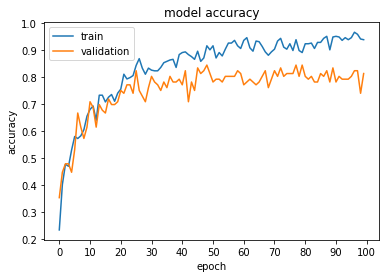

In [28]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()